## Building a Classification Dataset for Baseline Modeling
- Integrate ECG machine measurements, hospital diagnoses, and emergency department icd_titles
- Looking into procedures and how they connect to diagnoses (start w/ hosp module)

In [1]:
import pandas as pd
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.signal import butter, filtfilt, iirnotch
import copy

In [ ]:
#FROM MIMIC-IV ECG
machine_measurements_path = "machine_measurements.csv"
ecg_path = "record_list.csv"

#FROM MIMIC_IV HOSP
hosp_diagnosis = 'hosp_diagnosis.csv'

#FROM MIMIC_IV ED
ed_diagnosis = 'ed_diagnoses.csv'
ed_stays = 'ed_stays.csv'
#FROM MIMIC_IV ICU

In [4]:
df_machine_measurements = pd.read_csv(machine_measurements_path)
df_ecg = pd.read_csv(ecg_path)
df_hosp_diagnosis = pd.read_csv(hosp_diagnosis)
df_ed_diagnosis = pd.read_csv(ed_diagnosis)

/tmp/ipykernel_394/1361005052.py:1: DtypeWarning: Columns (16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_machine_measurements = pd.read_csv(machine_measurements_path)


In [5]:
#HELPER FUNCTIONS
def find_datetime_col(df: pd.DataFrame, candidates):
    """Return the first column name in candidates that exists in df, else None."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

def make_datetime(df: pd.DataFrame, col_candidates, new_col_name):
    """Try to coerce the timestamp column from candidates into new_col_name in df."""
    col = find_datetime_col(df, col_candidates)
    if col is None:
        df[new_col_name] = pd.NaT
        return None
    df[new_col_name] = pd.to_datetime(df[col], errors="coerce")
    return col

def safe_list_join(items, sep=" ; "):
    items = [str(x).strip() for x in items if pd.notna(x) and str(x).strip() != ""]
    return sep.join(dict.fromkeys(items))  # dedupe while preserving order

In [6]:
df_machine_measurements.columns

Index(['subject_id', 'study_id', 'cart_id', 'ecg_time', 'report_0', 'report_1',
       'report_2', 'report_3', 'report_4', 'report_5', 'report_6', 'report_7',
       'report_8', 'report_9', 'report_10', 'report_11', 'report_12',
       'report_13', 'report_14', 'report_15', 'report_16', 'report_17',
       'bandwidth', 'filtering', 'rr_interval', 'p_onset', 'p_end',
       'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis'],
      dtype='object')

In [7]:
#Normalize machine measurement text columns and numeric retention
# Identify report columns robustly
report_cols = [c for c in df_machine_measurements.columns if c.startswith("report_")]
# also include 'filtering' as text if present
if "filtering" in df_machine_measurements.columns:
    report_cols = report_cols + ["filtering"]

# Ensure report columns are strings
for c in report_cols:
    # Use pandas "string" dtype if available, else object str
    try:
        df_machine_measurements[c] = df_machine_measurements[c].astype("string")
    except Exception:
        df_machine_measurements[c] = df_machine_measurements[c].astype(str)

# Create one combined full_report (preserve order and skip empty/nan)
def combine_report_row(row):
    parts = []
    for c in report_cols:
        if c in row.index:
            v = row[c]
            if pd.isna(v):
                continue
            s = str(v).strip()
            if s == "" or s.lower() in {"nan", "none"}:
                continue
            parts.append(s)
    return " ".join(parts)

df_machine_measurements["full_report"] = df_machine_measurements[report_cols].apply(combine_report_row, axis=1)

# Keep all numeric columns (we will keep them as-is per ECG)
numeric_cols = df_machine_measurements.select_dtypes(include=[np.number]).columns.tolist()

# Also keep non-numeric machine columns we want (subject_id, study_id, ecg_time, path, hadm_id if present)
keep_cols = ["subject_id", "study_id", "cart_id", "ecg_time"]
keep_cols = [c for c in keep_cols if c in df_machine_measurements.columns]

# Make a working df that is one-row-per-ECG
df_ecg_level = df_machine_measurements[keep_cols + numeric_cols + ["full_report"]].copy()

# 🔥 Drop duplicated column names
df_ecg_level = df_ecg_level.loc[:, ~df_ecg_level.columns.duplicated()]

# Convert ecg_time → datetime
df_ecg_level["ecg_time_dt"] = pd.to_datetime(df_ecg_level["ecg_time"], errors="coerce")

In [8]:
df_ecg_level

,subject_id,study_id,cart_id,ecg_time,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,full_report,ecg_time_dt
0,10000032,40689238,6848296,2180-07-23 08:44:00,659,40,128,170,258,518,81,77,79,Sinus rhythm Possible right atrial abnormality...,2180-07-23 08:44:00
1,10000032,44458630,6848296,2180-07-23 09:54:00,722,40,124,162,246,504,77,75,70,Sinus rhythm Possible right atrial abnormality...,2180-07-23 09:54:00
2,10000032,49036311,6376932,2180-08-06 09:07:00,600,40,130,162,244,474,79,72,77,Sinus tachycardia Normal ECG except for rate 6...,2180-08-06 09:07:00
3,10000117,45090959,6214760,2181-03-04 17:14:00,659,40,146,180,254,538,79,66,69,Sinus rhythm Normal ECG 60 Hz notch Baseline f...,2181-03-04 17:14:00
4,10000117,48446569,6632385,2183-09-18 13:52:00,659,368,29999,504,590,868,84,80,77,Sinus rhythm <not specified>,2183-09-18 13:52:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800030,19999840,48683947,6283529,2164-09-12 12:28:00,659,40,154,182,266,560,38,-39,35,Sinus rhythm. Left axis deviation Borderline E...,2164-09-12 12:28:00
800031,19999840,41842293,6947865,2164-09-17 11:31:00,967,29999,29999,200,350,688,29999,-80,174,Accelerated idioventricular rhythm. Left axis ...,2164-09-17 11:31:00
800032,19999987,41190887,6848296,2145-11-02 19:54:00,526,40,148,204,286,528,58,50,51,Sinus tachycardia with PVC(s). Possible right ...,2145-11-02 19:54:00
800033,19999987,45828463,6315641,2145-11-03 03:00:00,631,40,156,202,282,570,59,54,56,Sinus rhythm. Normal ECG 60 Hz notch Baseline ...,2145-11-03 03:00:00


In [9]:
#Let's integrate Hosp Diagnoses!
hosp = df_hosp_diagnosis.copy()
hosp = hosp.drop(columns = ['icd_code_1', 'icd_version_1'])
hosp.head()

#Identify ICD and text columns
hosp_icd_col = find_datetime_col(hosp, ["icd_code"])
hosp_text_col = find_datetime_col(hosp, ["long_title"])

hosp["icd_code"] = hosp[hosp_icd_col].astype(str).str.strip()
hosp["long_title"] = hosp[hosp_text_col].astype(str).str.strip()

hosp
hosp[(hosp['subject_id'] == 10000032)]

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
160404,10000032,22595853,1,5723,9,Portal hypertension
160405,10000032,22841357,1,07071,9,Unspecified viral hepatitis C with hepatic coma
160406,10000032,25742920,1,07054,9,Chronic hepatitis C without mention of hepatic...
160407,10000032,29079034,1,45829,9,Other iatrogenic hypotension
707614,10000032,22595853,2,78959,9,Other ascites
707615,10000032,22841357,2,78959,9,Other ascites
707616,10000032,25742920,2,78959,9,Other ascites
707617,10000032,29079034,2,07044,9,Chronic hepatitis C with hepatic coma
1246346,10000032,22595853,3,5715,9,Cirrhosis of liver without mention of alcohol
1246347,10000032,22841357,3,2875,9,"Thrombocytopenia, unspecified"


In [10]:
#On to Emergency Department
ed = df_ed_diagnosis.copy()
ed.head()
ed_icd_col = find_datetime_col(ed, ["icd_code"])
ed_text_col = find_datetime_col(ed, ["icd_title"])

ed["icd_code"] = ed[ed_icd_col].astype(str).str.strip()
ed["icd_title"] = ed[ed_text_col].astype(str).str.strip()

ed

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title
0,15547384,34442287.0,1.0,035,9.0,ERYSIPELAS
1,16253470,37248432.0,1.0,035,9.0,ERYSIPELAS
2,10396349,36517744.0,1.0,042,9.0,HIV DISEASE
3,10429665,38305760.0,1.0,042,9.0,HIV DISEASE
4,10446182,31712472.0,1.0,042,9.0,HIV DISEASE
...,...,...,...,...,...,...
799648,16295873,39652916.0,3.0,T401X1A,10.0,"Poisoning by heroin, accidental (unintentional..."
799649,19338208,38703180.0,3.0,T401X1A,10.0,"Poisoning by heroin, accidental (unintentional..."
799650,10093718,34192667.0,3.0,T401X2A,10.0,"Poisoning by heroin, intentional self-harm, in..."
799651,11427334,36064723.0,3.0,T402X1A,10.0,"Poisoning by oth opioids, accidental (unintent..."


In [11]:
admissions = pd.read_csv("hosp_admissions.csv")
admissions.head()

,subject_id,hadm_id,admittime,dischtime
0,10106244,26713233,2147-05-09T10:34:00,2147-05-12T13:43:00
1,13700703,20448599,2172-09-25T01:01:00,2172-10-03T13:25:00
2,15443666,27961368,2168-12-30T23:30:00,2169-01-05T16:02:00
3,16299919,26977065,2193-05-15T08:37:00,2193-05-17T16:03:00
4,14149715,24191358,2181-10-25T19:37:00,2181-10-29T14:38:00


In [12]:
admissions["admittime"] = pd.to_datetime(admissions["admittime"], errors="coerce")
admissions["dischtime"] = pd.to_datetime(admissions["dischtime"], errors="coerce")

In [13]:
# For each ECG, find the admission where ecg_time_dt is between admittime and dischtime
df_ecg_level_updated = df_ecg_level.merge(admissions, on="subject_id", how="left")

df_ecg_level_updated['hosp_overlap'] = (
    (df_ecg_level_updated['ecg_time_dt'] >= df_ecg_level_updated['admittime']) &
    (df_ecg_level_updated['ecg_time_dt'] <= df_ecg_level_updated['dischtime'])
)

# keep only the matching Hosp rows OR the row with the fewest NaNs, basically if its False, its unrelated to the ECG
df_ecg_level_updated = (
    df_ecg_level_updated.sort_values('hosp_overlap', ascending=False)
    .groupby(['subject_id','study_id'], as_index=False)
    .first()
)

In [14]:
# Merge diagnoses
df_ecg_hosp_combined = (
    hosp.groupby(['subject_id','hadm_id'])
    .agg({
        'icd_code': lambda x: " ; ".join(x.dropna().astype(str).str.strip()),
        'long_title': lambda x: " ; ".join(x.dropna().astype(str).str.strip())
    })
    .reset_index()
)


In [15]:
df_ecg_hosp = df_ecg_level_updated.merge(
    df_ecg_hosp_combined,
    on=['subject_id','hadm_id'],
    how='left'
)

In [16]:
df_ecg_hosp

,subject_id,study_id,cart_id,ecg_time,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,...,qrs_axis,t_axis,full_report,ecg_time_dt,hadm_id,admittime,dischtime,hosp_overlap,icd_code,long_title
0,10000032,40689238,6848296,2180-07-23 08:44:00,659,40,128,170,258,518,...,77,79,Sinus rhythm Possible right atrial abnormality...,2180-07-23 08:44:00,29079034.0,2180-07-23 12:35:00,2180-07-25 17:55:00,False,45829 ; 07044 ; 7994 ; 2761,Other iatrogenic hypotension ; Chronic hepatit...
1,10000032,44458630,6848296,2180-07-23 09:54:00,722,40,124,162,246,504,...,75,70,Sinus rhythm Possible right atrial abnormality...,2180-07-23 09:54:00,25742920.0,2180-08-05 23:44:00,2180-08-07 17:50:00,False,07054 ; 78959 ; V462 ; V462 ; 5715,Chronic hepatitis C without mention of hepatic...
2,10000032,49036311,6376932,2180-08-06 09:07:00,600,40,130,162,244,474,...,72,77,Sinus tachycardia Normal ECG except for rate 6...,2180-08-06 09:07:00,25742920.0,2180-08-05 23:44:00,2180-08-07 17:50:00,True,07054 ; 78959 ; V462 ; V462 ; 5715,Chronic hepatitis C without mention of hepatic...
3,10000117,45090959,6214760,2181-03-04 17:14:00,659,40,146,180,254,538,...,66,69,Sinus rhythm Normal ECG 60 Hz notch Baseline f...,2181-03-04 17:14:00,27988844.0,2183-09-18 18:10:00,2183-09-21 16:30:00,False,S72012A ; W010XXA ; Y93K1,Unspecified intracapsular fracture of left fem...
4,10000117,48446569,6632385,2183-09-18 13:52:00,659,368,29999,504,590,868,...,80,77,Sinus rhythm <not specified>,2183-09-18 13:52:00,27988844.0,2183-09-18 18:10:00,2183-09-21 16:30:00,False,S72012A ; W010XXA ; Y93K1,Unspecified intracapsular fracture of left fem...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800030,19999840,48436051,6806320,2164-09-12 05:13:00,451,40,156,184,272,510,...,-48,25,Sinus tachycardia with sinus arrhythmia with a...,2164-09-12 05:13:00,26071774.0,2164-07-25 00:27:00,2164-07-28 12:15:00,False,43491 ; 43820 ; 34590,"Cerebral artery occlusion, unspecified with ce..."
800031,19999840,48683947,6283529,2164-09-12 12:28:00,659,40,154,182,266,560,...,-39,35,Sinus rhythm. Left axis deviation Borderline E...,2164-09-12 12:28:00,26071774.0,2164-07-25 00:27:00,2164-07-28 12:15:00,False,43491 ; 43820 ; 34590,"Cerebral artery occlusion, unspecified with ce..."
800032,19999987,41190887,6848296,2145-11-02 19:54:00,526,40,148,204,286,528,...,50,51,Sinus tachycardia with PVC(s). Possible right ...,2145-11-02 19:54:00,NaN,NaT,NaT,False,NaN,NaN
800033,19999987,45828463,6315641,2145-11-03 03:00:00,631,40,156,202,282,570,...,54,56,Sinus rhythm. Normal ECG 60 Hz notch Baseline ...,2145-11-03 03:00:00,NaN,NaT,NaT,False,NaN,NaN


In [17]:
df_ecg_hosp[['full_report', 'long_title']].iloc[0]['full_report']

'Sinus rhythm Possible right atrial abnormality Borderline ECG 60 Hz notch Baseline filter'

In [18]:
df_ecg_hosp[['full_report', 'long_title']].iloc[0]['long_title']

'Other iatrogenic hypotension ; Chronic hepatitis C with hepatic coma ; Cachexia ; Hyposmolality and/or hyponatremia'

In [19]:
df_ecg_hosp[['full_report', 'long_title']].iloc[1]['full_report']


'Sinus rhythm Possible right atrial abnormality Borderline ECG 60 Hz notch Baseline filter'

In [20]:
df_ecg_hosp[['full_report', 'long_title']].iloc[1]['long_title']

'Chronic hepatitis C without mention of hepatic coma ; Other ascites ; Other dependence on machines, supplemental oxygen ; Person on outside of car injured in collision with other nonmotor vehicle in nontraffic accident ; Cirrhosis of liver without mention of alcohol'

In [21]:
#Ed_stays functions very similarly to admissions for hosp
df_ed_stays = pd.read_csv(ed_stays)
df_ed_stays

,subject_id,hadm_id,stay_id,intime,outtime
0,10000178,NaN,31721172,2157-04-08 09:58:00,2157-04-08 15:30:00
1,10004371,NaN,38482952,2182-05-14 14:08:00,2182-05-14 16:14:00
2,10005303,NaN,32459569,2135-07-05 12:10:00,2135-07-05 16:07:00
3,10005329,25902419.0,32044805,2138-08-11 19:09:00,2138-08-12 08:28:00
4,10009866,NaN,37316180,2123-01-28 16:36:00,2123-01-28 19:03:00
...,...,...,...,...,...
425082,11538734,NaN,34250128,2131-05-07 15:50:00,2131-05-07 23:30:00
425083,11671952,NaN,32196324,2145-01-19 12:24:00,2145-01-19 14:56:00
425084,14144245,NaN,35688779,2124-02-03 14:00:00,2124-02-03 14:55:00
425085,16131034,NaN,37629133,2191-04-21 15:20:00,2191-04-21 17:58:00


In [22]:
df_ed_stays['intime'] = pd.to_datetime(df_ed_stays['intime'])
df_ed_stays['outtime'] = pd.to_datetime(df_ed_stays['outtime'])

In [23]:
df_ecg_ed_hosp = df_ecg_hosp.merge(
    df_ed_stays[['subject_id','stay_id','hadm_id','intime','outtime']],
    on='subject_id',
    how='left'
)

df_ecg_ed_hosp['ed_overlap'] = (
    (df_ecg_ed_hosp['ecg_time_dt'] >= df_ecg_ed_hosp['intime']) &
    (df_ecg_ed_hosp['ecg_time_dt'] <= df_ecg_ed_hosp['outtime'])
)

# keep only the matching ED rows OR the row with the fewest NaNs
df_ecg_ed_hosp = (
    df_ecg_ed_hosp.sort_values('ed_overlap', ascending=False)
    .groupby(['subject_id','study_id'], as_index=False)
    .first()
)


In [24]:
# Merge diagnoses for emergency department
df_ecg_ed_combined = (
    df_ed_diagnosis.groupby(['subject_id','stay_id'])
    .agg({
        'icd_code': lambda x: " ; ".join(x.dropna().astype(str).str.strip()),
        'icd_title': lambda x: " ; ".join(x.dropna().astype(str).str.strip())
    })
    .reset_index()
)

df_ecg_hosp_ed = df_ecg_ed_hosp.merge(
    df_ecg_ed_combined,
    on=['subject_id','stay_id'],
    how='left'
)

In [25]:
#Rename columns to make more sense
df_ecg_hosp_ed = df_ecg_hosp_ed.rename(columns={
    'hadm_id_x': 'hadm_id_hosp',      # hospital admission ID
    'icd_code_x': 'icd_code_hosp',    # hospital ICD codes
    'long_title': 'diagnosis_hosp',   # hospital ICD titles
    'stay_id': 'stay_id_ed',          # ED stay ID
    'hadm_id_y': 'hadm_id_ed',        # ED admission ID (can differ from hospital)
    'intime': 'ed_intime',            # ED start
    'outtime': 'ed_outtime',          # ED end
    'icd_code_y': 'icd_code_ed',      # ED ICD codes
    'icd_title': 'icd_title_ed'       # ED ICD titles
})


## Basic Clinical Entity Extraction for Full_Report (MM), Diagnosis_Hosp (Hospital Module), and ICD_Title (ED Module)

In [27]:
df_ecg_hosp_ed.columns
#TEXTUAL COLS: full_report, icd_title_hosp, icd_title_ed

Index(['subject_id', 'study_id', 'cart_id', 'ecg_time', 'rr_interval',
       'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis',
       'qrs_axis', 't_axis', 'full_report', 'ecg_time_dt', 'hadm_id_hosp',
       'admittime', 'dischtime', 'hosp_overlap', 'icd_code_hosp',
       'diagnosis_hosp', 'stay_id_ed', 'hadm_id_ed', 'ed_intime', 'ed_outtime',
       'ed_overlap', 'icd_code_ed', 'icd_title_ed'],
      dtype='object')

In [28]:
import re

ENTITY_KEYWORDS = {
    'Normal': [
        'normal', 'sinus rhythm', 'p wave', 'qrs complex'
    ],
    'Abnormal': [
        'abnormal', 'atrial abnormality', 'right atrial abnormality',
        'left atrial enlargement', 'ventricular hypertrophy', 'bundle branch block',
        'fibrillation', 'infarct', 'ischemia', 'lvh', 'rbbb', 'lbbb', 'tachycardia', 'bradycardia'
    ],
    'Uncertain': [
        'possible', 'probable', 'borderline', 'undetermined', 'may be'
    ],
    'Technical': ['baseline', 'filter', 'hz', 'notch', 'leads', 'v1', '1st']
}


import re

def extract_entities_strict(report, ENTITY_KEYWORDS):
    report_lower = report.lower()
    entities_found = {k: [] for k in ENTITY_KEYWORDS.keys()}
    
    for category, keywords in ENTITY_KEYWORDS.items():
        for kw in keywords:
            # match full words or phrases only
            if re.search(r'\b' + re.escape(kw.lower()) + r'\b', report_lower):
                entities_found[category].append(kw)
    
    entities_found = {k: list(set(v)) for k, v in entities_found.items()}
    return entities_found



# Apply to your dataframe
df_ecg_hosp_ed['extracted_entities'] = df_ecg_hosp_ed['full_report'].apply(
    lambda x: extract_entities_strict(x, ENTITY_KEYWORDS)
)

# Quick check
df_ecg_hosp_ed[['full_report', 'extracted_entities']].head()

,full_report,extracted_entities
0,Sinus rhythm Possible right atrial abnormality...,"{'Normal': ['sinus rhythm'], 'Abnormal': ['rig..."
1,Sinus rhythm Possible right atrial abnormality...,"{'Normal': ['sinus rhythm'], 'Abnormal': ['rig..."
2,Sinus tachycardia Normal ECG except for rate 6...,"{'Normal': ['normal'], 'Abnormal': ['tachycard..."
3,Sinus rhythm Normal ECG 60 Hz notch Baseline f...,"{'Normal': ['sinus rhythm', 'normal'], 'Abnorm..."
4,Sinus rhythm <not specified>,"{'Normal': ['sinus rhythm'], 'Abnormal': [], '..."


In [29]:
from collections import Counter
import re

# 1. Combine all diagnosis_hosp text into one big string
all_diagnoses = df_ecg_hosp_ed['diagnosis_hosp'].dropna().str.lower().tolist()
all_text = " ".join(all_diagnoses)

# 2. Tokenize into words (simple split on non-word characters)
tokens = re.findall(r'\b\w+\b', all_text)

# 3. Count frequency of each word
word_counts = Counter(tokens)

# 4. Show top N most frequent words
top_words = word_counts.most_common(100)
print(top_words)
# Your top 100 words
top_words = [word for word, count in top_words]  # get just the words

# Define a basic cardiovascular filter
cardio_keywords_manual = [
    'heart', 'coronary', 'infarction', 'atrial', 'fibrillation', 'myocardial',
    'ventricular', 'congestive', 'systolic', 'diastolic', 'hypertension',
    'hypertensive', 'artery', 'ischemia', 'block', 'bundle', 'rbbb', 'lbbb',
    'tachycardia', 'bradycardia', 'valve', 'stenosis', 'oxygen'
]

# Filter only words in your top_words
diagnosis_keywords = [kw for kw in cardio_keywords_manual if kw in top_words]
print(diagnosis_keywords)


[('of', 505971), ('unspecified', 454058), ('other', 204598), ('and', 199283), ('failure', 188822), ('acute', 187398), ('chronic', 184799), ('with', 177298), ('disease', 146351), ('kidney', 145390), ('or', 136927), ('heart', 134285), ('without', 110382), ('type', 80098), ('stage', 79213), ('not', 74682), ('in', 67184), ('specified', 63320), ('mention', 62476), ('to', 59596), ('pain', 50074), ('coronary', 49183), ('on', 47871), ('malignant', 47761), ('due', 46592), ('neoplasm', 46477), ('initial', 43559), ('the', 42733), ('hypertension', 42633), ('diabetes', 42375), ('encounter', 41524), ('diastolic', 41072), ('infection', 40438), ('infarction', 39777), ('as', 39555), ('congestive', 39324), ('essential', 37640), ('renal', 36713), ('systolic', 35391), ('fracture', 34947), ('site', 34701), ('atrial', 33586), ('hypertensive', 33060), ('respiratory', 32910), ('elsewhere', 32674), ('classified', 32059), ('end', 32007), ('artery', 31527), ('history', 31385), ('complication', 30541), ('pneumoni

In [30]:
import re

def extract_diagnosis_entities(diagnosis, keywords):
    """
    Extracts cardiovascular-relevant diagnosis entities from a diagnosis text.
    Returns a list of matched keywords.
    """
    if pd.isna(diagnosis):
        return []

    diagnosis_lower = diagnosis.lower()
    found = []
    
    for kw in keywords:
        if re.search(r'\b' + re.escape(kw.lower()) + r'\b', diagnosis_lower):
            found.append(kw)
    
    # Remove duplicates
    return list(set(found))

# Apply to your dataframe
df_ecg_hosp_ed['diagnosis_entities'] = df_ecg_hosp_ed['diagnosis_hosp'].apply(
    lambda x: extract_diagnosis_entities(x, diagnosis_keywords)
)

# Optional: count of diagnosis entities
df_ecg_hosp_ed['num_diagnosis_entities'] = df_ecg_hosp_ed['diagnosis_entities'].apply(len)

# Quick check
df_ecg_hosp_ed[['diagnosis_hosp', 'diagnosis_entities', 'num_diagnosis_entities']].head()


,diagnosis_hosp,diagnosis_entities,num_diagnosis_entities
0,Other iatrogenic hypotension ; Chronic hepatit...,[],0
1,Chronic hepatitis C without mention of hepatic...,[],0
2,Chronic hepatitis C without mention of hepatic...,[],0
3,Unspecified intracapsular fracture of left fem...,[],0
4,Unspecified intracapsular fracture of left fem...,[],0


In [66]:
#Focusing on cardiovascular diagnosis information
ED_CV_KEYWORDS = {
    "Arrhythmia": [
        "atrial fibrillation", "atrial flutter",
        "unspecified atrial fibrillation", "unspecified atrial flutter",
        "palpitations", "ventricular tachycardia",
        "bradycardia", "dysrhythmia"
    ],

    "Ischemic": [
        "myocardial infarction", "infarction",
        "stemi", "nstemi",
        "acute ischemic heart disease",
        "intermed coronary synd"
    ],

    "Heart Failure": [
        "heart failure", "congestive heart failure", "chf"
    ],

    "Chest Pain / Symptoms": [
        "chest pain", "other chest pain", "chest pain nos", "upper quadrant pain",
        "shortness of breath", "dyspnea",
        "syncope", "collapse",
        "dizziness", "giddiness"
    ],

    "Vascular / Embolic": [
        "pulmonary embolism", "embolism",
        "cerebral infarction", 
        "cerebral art occlus", 
        "infarct"
    ],

    "Cardiac Arrest": [
        "cardiac arrest", "asystole"
    ],

    "Structural / Cardiomyopathy": [
        "cardiomyopathy", "hypertrophy"
    ]
}


In [67]:
import re

def extract_ed_entities(title):
    if pd.isna(title):
        return {}   # no ED diagnosis for this ECG → return empty
    
    text = title.lower()
    extracted = {k: [] for k in ED_CV_KEYWORDS.keys()}
    
    found_any = False
    
    for category, kws in ED_CV_KEYWORDS.items():
        for kw in kws:
            if re.search(r'\b' + re.escape(kw) + r'\b', text):
                extracted[category].append(kw)
                found_any = True
    
    # If nothing matched → return an empty dict
    if not found_any:
        return {}
    
    # Otherwise, return structured extraction
    return {k: list(set(v)) for k, v in extracted.items()}

df_ecg_hosp_ed['ed_entities'] = df_ecg_hosp_ed['icd_title_ed'].apply(extract_ed_entities)


## Plotting Distributions of Clinical Entity Extractions: Machine Measurement Information, Emergency Department ICD_Titles, and Hospital Diagnoses

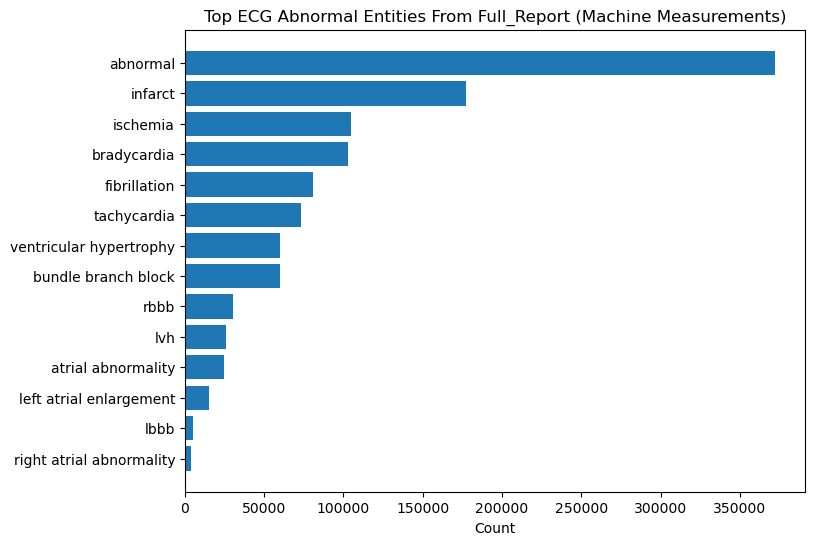

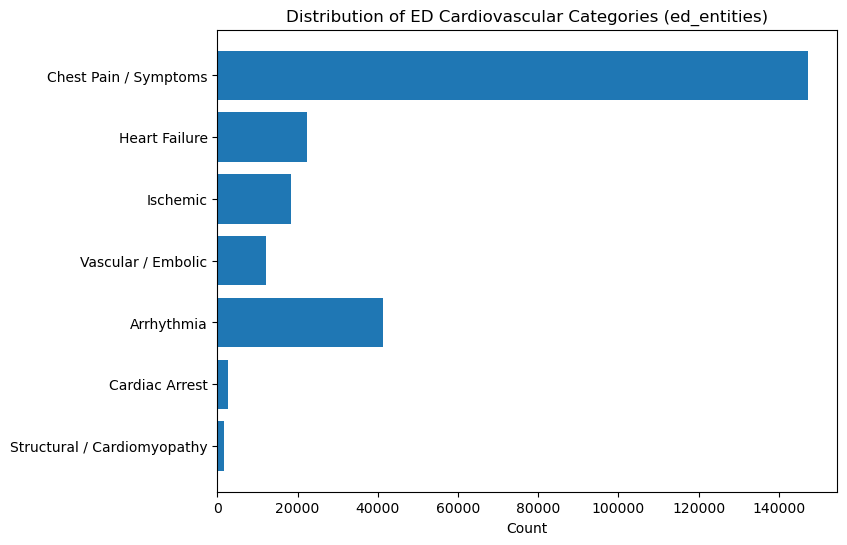

<Figure size 1000x600 with 0 Axes>

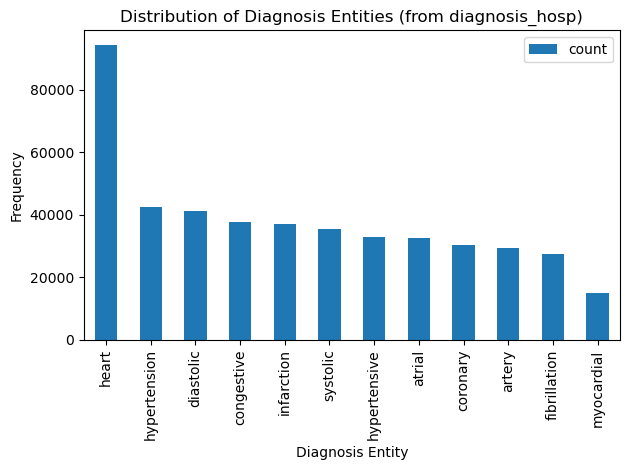

In [97]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten abnormal entities across all rows
abnormal_list = [
    ent 
    for row in df_ecg_hosp_ed['extracted_entities']
    for ent in row.get('Abnormal', [])
]

counts_abnormal = Counter(abnormal_list).most_common(20)  # top 20

labels, values = zip(*counts_abnormal)

plt.figure(figsize=(8,6))
plt.barh(labels, values)
plt.title("Top ECG Abnormal Entities From Full_Report (Machine Measurements)")
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.show()


from collections import Counter

flat_categories = []

for d in df_ecg_hosp_ed['ed_entities']:
    if isinstance(d, dict):
        for k, v in d.items():
            if len(v) > 0:
                flat_categories.append(k)

counts_ed_cardiac = Counter(flat_categories)

labels, values = zip(*counts_ed_cardiac.items())

plt.figure(figsize=(8,6))
plt.barh(labels, values)
plt.title("Distribution of ED Cardiovascular Categories (ed_entities)")
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# --- 1. Flatten all diagnosis entity lists ---
all_diag_entities = []

for entities in df_ecg_hosp_ed['diagnosis_entities']:
    if isinstance(entities, list):
        all_diag_entities.extend(entities)

# --- 2. Count them ---
diagnosis_counts = Counter(all_diag_entities)

# If empty, warn
if len(diagnosis_counts) == 0:
    print("No diagnosis entities found.")
else:
    # --- 3. Convert to DataFrame for easy plotting ---
    diag_df = pd.DataFrame.from_dict(diagnosis_counts, orient='index', columns=['count'])
    diag_df = diag_df.sort_values('count', ascending=False)

    # --- 4. Plot ---
    plt.figure(figsize=(10, 6))
    diag_df.plot(kind='bar')
    plt.title("Distribution of Diagnosis Entities (from diagnosis_hosp)")
    plt.ylabel("Frequency")
    plt.xlabel("Diagnosis Entity")
    plt.tight_layout()
    plt.show()


## Exploring Procedures - Hosp Module

In [153]:
# # ONLY RUN THIS ONCE
# file_path = 'hosp_procedures.csv'

# # Read all lines
# with open(file_path, 'r', errors='replace') as f:
#     lines = f.readlines()

# # Remove all trailing quotes from the last line, then add a single closing quote
# lines[513240] = lines[513240].rstrip('"\n') + '"\n'

# # Write back to the same file
# with open(file_path, 'w') as f:
#     f.writelines(lines)

# print("Broken last line fixed cleanly!")

Broken last line fixed cleanly!


In [157]:
df_hosp_procedures = pd.read_csv(
    'hosp_procedures.csv',
    engine='python',
    on_bad_lines='skip'  # skips rows with unexpected number of fields
)

In [166]:
#df_hosp_procedures = df_hosp_procedures.drop(columns = ['icd_code_1', 'icd_version_1'])
df_hosp_procedures

,icd_code,icd_version,long_title,subject_id,hadm_id,seq_num,chartdate
0,0009,9,Other therapeutic ultrasound,10232455,26467493,3,2160-02-08
1,0010,9,Implantation of chemotherapeutic agent,10804175,24850822,1,2193-06-08
2,0010,9,Implantation of chemotherapeutic agent,10804175,26620939,1,2193-06-08
3,0010,9,Implantation of chemotherapeutic agent,11419849,20306572,1,2160-03-23
4,0010,9,Implantation of chemotherapeutic agent,11419849,22603594,1,2160-06-18
...,...,...,...,...,...,...,...
851345,XW24346,10,Transfusion of Brexucabtagene Autoleucel Immun...,12021397,27581664,1,2149-10-13
851346,XW24376,10,Transfusion of Lisocabtagene Maraleucel Immuno...,18701032,26541751,1,2156-07-28
851347,XW24376,10,Transfusion of Lisocabtagene Maraleucel Immuno...,17212516,24513767,2,2166-11-10
851348,XY0VX83,10,Extracorporeal Introduction of Endothelial Dam...,13472388,29192377,4,2141-04-25


In [161]:
df_ecg_hosp_ed.columns

Index(['subject_id', 'study_id', 'cart_id', 'ecg_time', 'rr_interval',
       'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis',
       'qrs_axis', 't_axis', 'full_report', 'ecg_time_dt', 'hadm_id_hosp',
       'admittime', 'dischtime', 'hosp_overlap', 'icd_code_hosp',
       'diagnosis_hosp', 'stay_id_ed', 'hadm_id_ed', 'ed_intime', 'ed_outtime',
       'ed_overlap', 'icd_code_ed', 'icd_title_ed', 'extracted_entities',
       'diagnosis_entities', 'num_diagnosis_entities', 'ed_entities',
       'num_ed_entities'],
      dtype='object')

In [178]:
# Aggregate procedures into a list per hadm_id
df_procs_agg = df_hosp_procedures.groupby('hadm_id')['long_title'].apply(list).reset_index()

# Merge aggregated procedures
df_merged = df_ecg_hosp_ed.merge(
    df_procs_agg,
    left_on='hadm_id_hosp',
    right_on='hadm_id',
    how='left'
)

df_merged = df_merged.rename(columns = {'hadm_id': 'hadm_id_hosp_proc', 'long_title': 'hosp_procedure'})

## DF_MERGED is a complete dataframe including hospital-specific procedures (matched with hadm_id_hosp)

In [190]:
df_merged

,subject_id,study_id,cart_id,ecg_time,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,...,ed_overlap,icd_code_ed,icd_title_ed,extracted_entities,diagnosis_entities,num_diagnosis_entities,ed_entities,num_ed_entities,hadm_id_hosp_proc,hosp_procedure
0,10000032,40689238,6848296,2180-07-23 08:44:00,659,40,128,170,258,518,...,True,78097 ; 34830,"ALTERED MENTAL STATUS ; ENCEPHALOPATHY, UNSPEC...","{'Normal': ['sinus rhythm'], 'Abnormal': ['rig...",[],0,{},0,NaN,NaN
1,10000032,44458630,6848296,2180-07-23 09:54:00,722,40,124,162,246,504,...,True,78097 ; 34830,"ALTERED MENTAL STATUS ; ENCEPHALOPATHY, UNSPEC...","{'Normal': ['sinus rhythm'], 'Abnormal': ['rig...",[],0,{},0,25742920.0,[Percutaneous abdominal drainage]
2,10000032,49036311,6376932,2180-08-06 09:07:00,600,40,130,162,244,474,...,False,4589 ; 07070 ; V08,HYPOTENSION NOS ; UNSPECIFIED VIRAL HEPATITIS ...,"{'Normal': ['normal'], 'Abnormal': ['tachycard...",[],0,{},0,25742920.0,[Percutaneous abdominal drainage]
3,10000117,45090959,6214760,2181-03-04 17:14:00,659,40,146,180,254,538,...,False,S098XXA ; S01111A,"Other specified injuries of head, initial enco...","{'Normal': ['sinus rhythm', 'normal'], 'Abnorm...",[],0,{},0,27988844.0,[Reposition Left Upper Femur with Internal Fix...
4,10000117,48446569,6632385,2183-09-18 13:52:00,659,368,29999,504,590,868,...,True,S72092A ; W1830XA,"Oth fracture of head and neck of left femur, i...","{'Normal': ['sinus rhythm'], 'Abnormal': [], '...",[],0,{},0,27988844.0,[Reposition Left Upper Femur with Internal Fix...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800030,19999840,48436051,6806320,2164-09-12 05:13:00,451,40,156,184,272,510,...,False,NaN,NaN,"{'Normal': ['normal'], 'Abnormal': ['tachycard...","[artery, infarction]",2,{},0,26071774.0,"[Arteriography of cerebral arteries, Magnetic ..."
800031,19999840,48683947,6283529,2164-09-12 12:28:00,659,40,154,182,266,560,...,False,NaN,NaN,"{'Normal': ['sinus rhythm'], 'Abnormal': [], '...","[artery, infarction]",2,{},0,26071774.0,"[Arteriography of cerebral arteries, Magnetic ..."
800032,19999987,41190887,6848296,2145-11-02 19:54:00,526,40,148,204,286,528,...,True,431,INTRACEREBRAL HEMORRHAGE,"{'Normal': [], 'Abnormal': ['right atrial abno...",[],0,{},0,NaN,NaN
800033,19999987,45828463,6315641,2145-11-03 03:00:00,631,40,156,202,282,570,...,False,431,INTRACEREBRAL HEMORRHAGE,"{'Normal': ['sinus rhythm', 'normal'], 'Abnorm...",[],0,{},0,NaN,NaN


In [191]:
df_merged.columns

Index(['subject_id', 'study_id', 'cart_id', 'ecg_time', 'rr_interval',
       'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis',
       'qrs_axis', 't_axis', 'full_report', 'ecg_time_dt', 'hadm_id_hosp',
       'admittime', 'dischtime', 'hosp_overlap', 'icd_code_hosp',
       'diagnosis_hosp', 'stay_id_ed', 'hadm_id_ed', 'ed_intime', 'ed_outtime',
       'ed_overlap', 'icd_code_ed', 'icd_title_ed', 'extracted_entities',
       'diagnosis_entities', 'num_diagnosis_entities', 'ed_entities',
       'num_ed_entities', 'hadm_id_hosp_proc', 'hosp_procedure'],
      dtype='object')

In [192]:
df_merged

,subject_id,study_id,cart_id,ecg_time,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,...,ed_overlap,icd_code_ed,icd_title_ed,extracted_entities,diagnosis_entities,num_diagnosis_entities,ed_entities,num_ed_entities,hadm_id_hosp_proc,hosp_procedure
0,10000032,40689238,6848296,2180-07-23 08:44:00,659,40,128,170,258,518,...,True,78097 ; 34830,"ALTERED MENTAL STATUS ; ENCEPHALOPATHY, UNSPEC...","{'Normal': ['sinus rhythm'], 'Abnormal': ['rig...",[],0,{},0,NaN,NaN
1,10000032,44458630,6848296,2180-07-23 09:54:00,722,40,124,162,246,504,...,True,78097 ; 34830,"ALTERED MENTAL STATUS ; ENCEPHALOPATHY, UNSPEC...","{'Normal': ['sinus rhythm'], 'Abnormal': ['rig...",[],0,{},0,25742920.0,[Percutaneous abdominal drainage]
2,10000032,49036311,6376932,2180-08-06 09:07:00,600,40,130,162,244,474,...,False,4589 ; 07070 ; V08,HYPOTENSION NOS ; UNSPECIFIED VIRAL HEPATITIS ...,"{'Normal': ['normal'], 'Abnormal': ['tachycard...",[],0,{},0,25742920.0,[Percutaneous abdominal drainage]
3,10000117,45090959,6214760,2181-03-04 17:14:00,659,40,146,180,254,538,...,False,S098XXA ; S01111A,"Other specified injuries of head, initial enco...","{'Normal': ['sinus rhythm', 'normal'], 'Abnorm...",[],0,{},0,27988844.0,[Reposition Left Upper Femur with Internal Fix...
4,10000117,48446569,6632385,2183-09-18 13:52:00,659,368,29999,504,590,868,...,True,S72092A ; W1830XA,"Oth fracture of head and neck of left femur, i...","{'Normal': ['sinus rhythm'], 'Abnormal': [], '...",[],0,{},0,27988844.0,[Reposition Left Upper Femur with Internal Fix...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800030,19999840,48436051,6806320,2164-09-12 05:13:00,451,40,156,184,272,510,...,False,NaN,NaN,"{'Normal': ['normal'], 'Abnormal': ['tachycard...","[artery, infarction]",2,{},0,26071774.0,"[Arteriography of cerebral arteries, Magnetic ..."
800031,19999840,48683947,6283529,2164-09-12 12:28:00,659,40,154,182,266,560,...,False,NaN,NaN,"{'Normal': ['sinus rhythm'], 'Abnormal': [], '...","[artery, infarction]",2,{},0,26071774.0,"[Arteriography of cerebral arteries, Magnetic ..."
800032,19999987,41190887,6848296,2145-11-02 19:54:00,526,40,148,204,286,528,...,True,431,INTRACEREBRAL HEMORRHAGE,"{'Normal': [], 'Abnormal': ['right atrial abno...",[],0,{},0,NaN,NaN
800033,19999987,45828463,6315641,2145-11-03 03:00:00,631,40,156,202,282,570,...,False,431,INTRACEREBRAL HEMORRHAGE,"{'Normal': ['sinus rhythm', 'normal'], 'Abnorm...",[],0,{},0,NaN,NaN


In [195]:
df_merged.to_csv('potential_classification_dataset.csv')